In [66]:
from functools import partial
from typing import List
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import brute
import cirq
import openfermion as of
from openfermionpyscf import generate_molecular_hamiltonian

from mitiq import PauliString, Observable, Executor, zne  # Zero-noise extrapolation module
from mitiq.interface.mitiq_cirq import compute_density_matrix

In [67]:
radii = [0.2 * i for i in range(1, 14)]

def qubit_operator_to_pauli_sum(qubit_op) -> List:
    """Converts the OpenFermion qubit operator to a list of mitiq Pauli Strings."""
    psum = []
    for ind_ops, coeff in qubit_op.terms.items():
        if ind_ops == tuple():
            psum.append(PauliString("I", coeff))
            continue
        term = ["I", "I"]
        for ind, op in ind_ops:
            term[ind] = op
        term = ''.join(term)
        psum.append(PauliString(term, coeff))
    return psum

def get_hamiltonian(bond_length=0.7414) -> Observable:
    """Returns the hamiltonian for the H2 molecule at the given bond length. Uses the STO-6G basis set and the Bravyi-Kitaev
    transform to map fermionic operators to qubits. Results in a 2 qubit hamiltonian returned via a metriq.Observable."""
    geometry = [('H', (0., 0., 0.)), ('H', (0., 0., bond_length))]
    molecular_hamiltonian = generate_molecular_hamiltonian(geometry, basis='sto-6g', multiplicity=1, charge=0)
    fermionic_op = of.transforms.get_fermion_operator(molecular_hamiltonian)
    bk_op = of.transforms.symmetry_conserving_bravyi_kitaev(fermionic_op, active_orbitals=4, active_fermions=2)
    qubit_operator = qubit_operator_to_pauli_sum(bk_op)
    return Observable(*qubit_operator)

hamiltonians = get_hamiltonian(0.7414)
print(hamiltonians)

(-0.3477762456868043+0j)*I + (0.3943982566281438+0j)*Z(q(0)) + (0.39439825662814376+0j)*Z(q(1)) + (0.011280181225500119+0j)*Z(q(0))*Z(q(1)) + (0.18157637663956305+0j)*X(q(0))*X(q(1))


In [68]:
def ansatz(theta: float) -> cirq.Circuit:
    """Returns the circuit associated to the input variational parameter."""
    qreg = cirq.LineQubit.range(2)
    return cirq.Circuit(
        cirq.ops.ry(np.pi / 2).on(qreg[0]),
        cirq.ops.rx(-np.pi / 2).on(qreg[1]),
        cirq.ops.CNOT.on(*qreg),
        cirq.ops.rz(theta).on(qreg[1]),
        cirq.ops.CNOT.on(*qreg),
        cirq.ops.ry(-np.pi / 2).on(qreg[0]),
        cirq.ops.rx(np.pi / 2).on(qreg[1]),
    )

In [69]:
# Noise levels
pvals = (0.00, 0.02, 0.04)
# Variational parameters
thetas = np.linspace(0.0, 2.0 * np.pi, 50)

all_energies = []
for pval in pvals:
    energies = []
    for theta in thetas:
        results = hamiltonians.expectation(ansatz(theta), execute=partial(compute_density_matrix, noise_model_function=cirq.depolarize, noise_level=(pval,)))
        energies.append(np.real(results))
    all_energies.append(energies)

In [70]:
# thetas

In [71]:
# min(all_energies[0]) , min(all_energies[1]) ,min(all_energies[2]) 
# l = [min(all_energies[i]) for i in range(3)]
# print(l)

In [72]:
# Set noise scaling method
scaling_function = zne.scaling.fold_global
# Set extrapolation method
fac = zne.inference.RichardsonFactory(scale_factors=[1, 3, 5])
# Set number of trials per expectation value
num_to_average = 1

# To reproduce the results of the Mitiq paper use the following settings
# scaling_function = zne.scaling.fold_gates_at_random
# pfac = zne.inference.PolyFactory(order=3,
#                           scale_factors=[1., 1.5, 2., 2.5, 3., 3.5, 4., 4.5, 5., 5.5, 6.])
# num_to_average = 5
# pvals = (0.00, 0.02, 0.04, 0.06)
# thetas = np.linspace(0.0, 2.0 * np.pi, 20)

all_mitigated = []
for p in pvals[1:]:
    mitigated = []
    for theta in thetas:
        # Define an executor function
        executor = Executor(partial(compute_density_matrix, noise_model_function=cirq.depolarize, noise_level=(p,)))
        # Run ZNE
        zne_value = zne.execute_with_zne(
            ansatz(theta),
            executor,
            hamiltonians,
            factory=fac,
            scale_noise=scaling_function,
            num_to_average=num_to_average,
        )
        mitigated.append(np.real(zne_value))
    all_mitigated.append(mitigated)

In [73]:
# k = [min(all_mitigated[i]) for i in range(2)]
# print(k)

Noise Value           Noisy Value          Error Mitigated Value   
0.00             -1.145456075668335              --------           optimized parameter(theta) = 3.333935060952433
0.02             -1.0071673393249512        -1.135985329747199
0.04             -0.8899964690208435        -1.0941657684743389

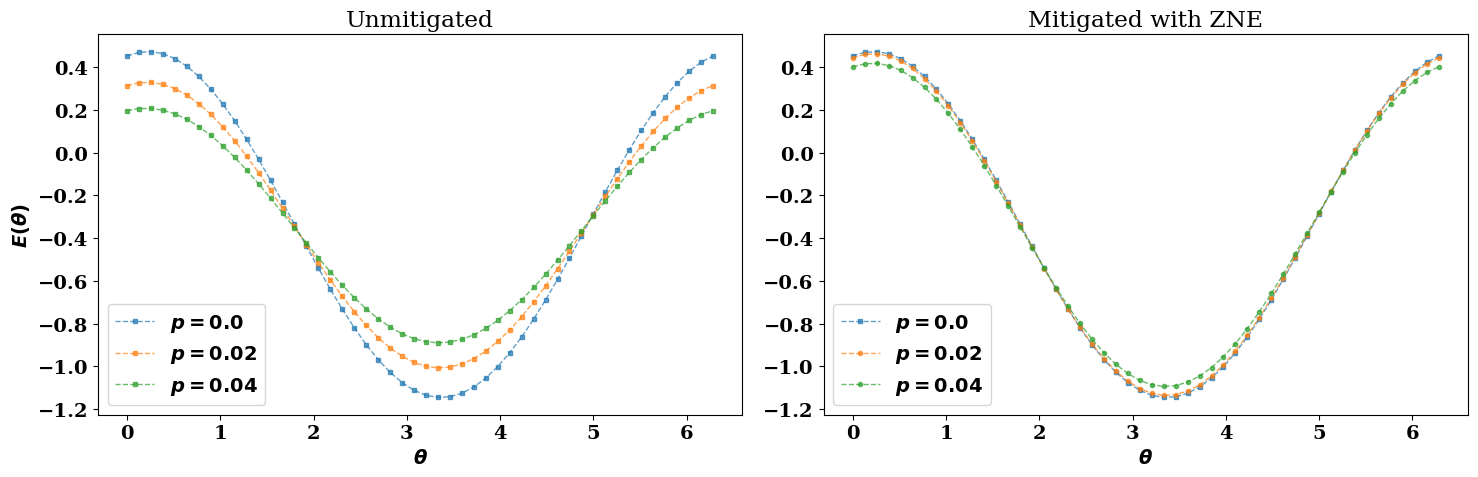

In [77]:
# plt.rcParams.update({"font.family": "serif", "font.size": 14, "font.weight": "bold"})
plt.figure(figsize=(15, 5))
# # Plot unmitigated results
plt.subplot(121)
plt.title("Unmitigated")
for i in range(len(all_energies)):
    plt.plot(
        thetas,
        all_energies[i],
        "--s",
        lw=1,
        markersize=3,
        #markeredgecolor="black",
        alpha=0.7,
        label=f"$p = {pvals[i]}$",
    )
plt.xlabel(r"$\theta$")
plt.ylabel(r"$E(\theta)$")
plt.legend()
plt.subplot(122)
plt.title("Mitigated with ZNE")
# Plot noiseless results
plt.plot(
    thetas,
    all_energies[0],
    "--s",
    lw=1,
    markersize=3,
    #markeredgecolor="black",
    alpha=0.7,
    label="$p = 0.0$",
)
# Plot error-mitigated results
for i in range(len(all_mitigated)):
    plt.plot(
        thetas,
        all_mitigated[i],
        "--o",
        lw=1,
        markersize=3,
        #markeredgecolor="black",
        alpha=0.7,
        label=f"$p = {pvals[i + 1]}$",
    )
plt.xlabel(r"$\theta$")
plt.legend()
plt.tight_layout()
plt.savefig("H2_vqe.png")

In [58]:
radii = [0.2 * i for i in range(1, 14)]

def qubit_operator_to_pauli_sum(qubit_op) -> List:
    """Converts the OpenFermion qubit operator to a list of mitiq Pauli Strings."""
    psum = []
    for ind_ops, coeff in qubit_op.terms.items():
        if ind_ops == tuple():
            psum.append(PauliString("I", coeff))
            continue
        term = ["I", "I"]
        for ind, op in ind_ops:
            term[ind] = op
        term = ''.join(term)
        psum.append(PauliString(term, coeff))
    return psum

def get_hamiltonian(bond_length) -> Observable:
    """Returns the hamiltonian for the H2 molecule at the given bond length. Uses the STO-6G basis set and the Bravyi-Kitaev
    transform to map fermionic operators to qubits. Results in a 2 qubit hamiltonian returned via a metriq.Observable."""
    geometry = [('H', (0., 0., 0.)), ('H', (0., 0., bond_length))]
    molecular_hamiltonian = generate_molecular_hamiltonian(geometry, basis='sto-6g', multiplicity=1, charge=0)
    fermionic_op = of.transforms.get_fermion_operator(molecular_hamiltonian)
    bk_op = of.transforms.symmetry_conserving_bravyi_kitaev(fermionic_op, active_orbitals=4, active_fermions=2)
    qubit_operator = qubit_operator_to_pauli_sum(bk_op)
    return Observable(*qubit_operator)

hamiltonians = [get_hamiltonian(i) for i in radii]
print(hamiltonians)

[<mitiq.observable.observable.Observable object at 0x7f7a54d120b0>, <mitiq.observable.observable.Observable object at 0x7f7a54d112a0>, <mitiq.observable.observable.Observable object at 0x7f7a54d11ab0>, <mitiq.observable.observable.Observable object at 0x7f7a54d11ba0>, <mitiq.observable.observable.Observable object at 0x7f7a54462bc0>, <mitiq.observable.observable.Observable object at 0x7f7a54d13490>, <mitiq.observable.observable.Observable object at 0x7f7b18336080>, <mitiq.observable.observable.Observable object at 0x7f7a54a3c490>, <mitiq.observable.observable.Observable object at 0x7f7a54a3f520>, <mitiq.observable.observable.Observable object at 0x7f7a54a3eda0>, <mitiq.observable.observable.Observable object at 0x7f7a544639d0>, <mitiq.observable.observable.Observable object at 0x7f7a546b5630>, <mitiq.observable.observable.Observable object at 0x7f7a54d5b310>]


In [59]:
print(hamiltonians[12])

(-0.6543223467096454+0j)*I + (0.02325291250869107+0j)*Z(q(0)) + (0.023252912508691097+0j)*Z(q(1)) + (0.00027610456347285095+0j)*Z(q(0))*Z(q(1)) + (0.28632754508480307+0j)*X(q(0))*X(q(1))


In [58]:
print(hamiltonians)

[<mitiq.observable.observable.Observable object at 0x7f580802ad70>, <mitiq.observable.observable.Observable object at 0x7f580802b970>, <mitiq.observable.observable.Observable object at 0x7f5808029ba0>, <mitiq.observable.observable.Observable object at 0x7f5808028790>, <mitiq.observable.observable.Observable object at 0x7f580802b2b0>, <mitiq.observable.observable.Observable object at 0x7f58080ad6c0>, <mitiq.observable.observable.Observable object at 0x7f58080ae8c0>, <mitiq.observable.observable.Observable object at 0x7f58171ea650>, <mitiq.observable.observable.Observable object at 0x7f580958ee90>, <mitiq.observable.observable.Observable object at 0x7f580958ee60>, <mitiq.observable.observable.Observable object at 0x7f5808c8b5b0>, <mitiq.observable.observable.Observable object at 0x7f5808c8a200>, <mitiq.observable.observable.Observable object at 0x7f5809521b10>]


In [53]:
radii

[0.2,
 0.4,
 0.6000000000000001,
 0.8,
 1.0,
 1.2000000000000002,
 1.4000000000000001,
 1.6,
 1.8,
 2.0,
 2.2,
 2.4000000000000004,
 2.6]

In [59]:
def ansatz(theta: float) -> cirq.Circuit:
    """Returns the circuit associated to the input variational parameter."""
    qreg = cirq.LineQubit.range(2)
    return cirq.Circuit(
        cirq.ops.ry(np.pi / 2).on(qreg[0]),
        cirq.ops.rx(-np.pi / 2).on(qreg[1]),
        cirq.ops.CNOT.on(*qreg),
        cirq.ops.rz(theta).on(qreg[1]),
        cirq.ops.CNOT.on(*qreg),
        cirq.ops.ry(-np.pi / 2).on(qreg[0]),
        cirq.ops.rx(np.pi / 2).on(qreg[1]),
    )

In [67]:
# Noise levels
pvals = (0.00, 0.02, 0.04)
# Variational parameters
thetas = np.linspace(0.0, 2.0 * np.pi, 10)

all_energies = []
for pval in pvals:
    energies = []
    for j in range(len(hamiltonians)):
        for theta in thetas:
            results = hamiltonians[j].expectation(ansatz(theta), execute=partial(compute_density_matrix, noise_model_function=cirq.depolarize, noise_level=(pval,)))
            energies.append(np.real(results))
        all_energies.append(min(energies))

In [70]:
all_energies

[0.21802833676338196,
 -0.8880183696746826,
 -1.1102937459945679,
 -1.1390634775161743,
 -1.1390634775161743,
 -1.1390634775161743,
 -1.1390634775161743,
 -1.1390634775161743,
 -1.1390634775161743,
 -1.1390634775161743,
 -1.1390634775161743,
 -1.1390634775161743,
 -1.1390634775161743,
 0.5535885095596313,
 -0.6537783741950989,
 -0.9401831030845642,
 -1.0112950801849365,
 -1.0112950801849365,
 -1.0112950801849365,
 -1.0112950801849365,
 -1.0112950801849365,
 -1.0112950801849365,
 -1.0112950801849365,
 -1.0112950801849365,
 -1.0112950801849365,
 -1.0112950801849365,
 0.8379753232002258,
 -0.4553820490837097,
 -0.7962402105331421,
 -0.9033365845680237,
 -0.9268258810043335,
 -0.9268258810043335,
 -0.9268258810043335,
 -0.9268258810043335,
 -0.9268258810043335,
 -0.9268258810043335,
 -0.9268258810043335,
 -0.9268258810043335,
 -0.9268258810043335]